This notebook preprocesses the ICON data to create input files for the firedanger tool written by Daniel Steinfeld. The preprocessing includes the selection of subregions, the time period, and variables and the interpolation from Healpix format to a lon-lat grid. Customization can be done in the first cell.

Limitations: The firedanger tool needs noon values for several variables. As output was only available on 3-hourly timesteps. For time zones where 12:00 values where not available due to the 3-hourly resolution of these variables, 11:00 or 13:00 values where selected instead. Relative humidity was computed from specific humidity.

In [1]:
# %history -g -f history.txt

In [16]:
if __name__ == "__main__":

    # customize inputs

    exp_id = "ngc4008"
    zoom=7                     # zoom level (should +/- fit with the resolution of the output)

    lon_min = -180.            # region to be selected (as lon/lat, use negative values for western/southern hemisphere)
    lon_max = 180.
    lat_min = -89.
    lat_max = 89.

    interpol_method="linear"    # choose one out of nearest, linear, cubic 

    time_min = "2020-01-02"    # first date to be selected as YYYY-MM-DD (do not use 2020-01-01)
    time_max = "2020-03-01"    # last date to be selected as YYYY-MM-DD

    res_out_x = 2              # resolution of the interpolated files in degree lon
    res_out_y = res_out_x      # resolution of the interpolated files in degree lat

    filename_out="test.nc"

In [17]:
# import libraries

import intake
import dask
from dask.diagnostics import ProgressBar
from multiprocessing import Pool, Manager
import pandas as pd
import functools
import itertools
# import cmocean
import metpy.calc
from metpy.units import units
import healpy
import xarray as xr
import numpy as np
from scipy import interpolate
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# import logging
from collections.abc import Iterable

In [18]:
# define functions

# def default_kwargs(**defaultKwargs):
#     def actual_decorator(fn):
#         @functools.wraps(fn)
#         def g(*args, **kwargs):
#             defaultKwargs.update(kwargs)
#             return fn(*args, **defaultKwargs)
#         return g
#     return actual_decorator

def get_nest(dx):
    return dx.crs.healpix_order == "nest"

def get_nside(dx):
    return dx.crs.healpix_nside

def attach_coords(ds):
    lons, lats = healpy.pix2ang(
        get_nside(ds), np.arange(ds.dims["cell"]), nest=get_nest(ds), lonlat=True
    )
    return ds.assign_coords(
        lat=(("cell",), lats, {"units": "degree_north"}),
        lon=(("cell",), lons, {"units": "degree_east"}),
    )

def compute_lhour(ds):
          
   lhour1 = 0 * ds.tas + ds.time.dt.hour + np.round(24/360*ds.lon)
   lhour2 = lhour1.where(lhour1>=0,lhour1+24)
   lhour3 = lhour2.where(lhour2<24,lhour2-24)
    
   return lhour3


def compute_noonvals(ds,arrayname,varname):

    # print("select noon values for ds: " + str(ds) + ", varname: " + varname +". output will be appended to " + arrayname)
    
    lhour=compute_lhour(ds)
    sel = np.where((lhour == 11) | (lhour == 12) | (lhour == 13),1,0)
    var_sel = eval("ds." + varname + "* sel")
    arrayname[varname] = var_sel.resample(time="D").sum()
    
    return arrayname[varname]

# @default_kwargs(interpol_method="linear")
def interpolate_healpy2lonlat(input_array,output_array,varname,inlon,inlat,outlon,outlat,*args,**kwargs):
 
    print("interpolation method: ",interpol_method)    
    
    outgrid=np.meshgrid(outlon,outlat)

    values_interpolated=np.empty((np.shape(input_array)[0],len(outlat),len(outlon)))

    i=0

    for date in input_array.time:
        values_tsel=input_array.sel(time=date) # .drop(time)
        values_interpolated[i][:][:] =  interpolate.griddata((inlon,inlat), values_tsel, (outgrid[0][:][:],outgrid[1][:][:]), method=interpol_method)
        i += 1

    output_array[varname] = values_interpolated
    
    return output_array[varname]

In [19]:
if __name__ == "__main__":

    # load datasets (ICON)

    cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
    experiment = cat.ICON[exp_id]

    ds_3h = experiment(time="PT3H", zoom=zoom, chunks="auto").to_dask().pipe(attach_coords)   # for 2m tempreature, precipitation, surface winds
    # ds_1d = experiment(time="P1D", zoom=zoom, chunks="auto").to_dask().pipe(attach_coords)    # for 2m spec. humidity

In [20]:
# [(x, ds_3h[x].attrs.get("long_name")) for x in ds_3h ] 

In [21]:
if __name__ == "__main__":

    # select region & pick (almost) noon-values for 3-hourly data
 
    # disclaimer: for time zones that do not have 12:00:00 values be relaxed by +/-1 hour

    ds_3h.lon[ds_3h.lon>180]=ds_3h.lon[ds_3h.lon>180]-360
    ds_3h_reg=ds_3h.sel(time=slice(time_min,time_max)).where((ds_3h.lon > lon_min) & (ds_3h.lon < lon_max) & (ds_3h.lat > lat_min) & (ds_3h.lat < lat_max),drop=True)

In [22]:
if __name__ == "__main__":

    maxpoolsize = 4

    varlist = ['tas','pr','uas','vas','qv2m','pres_sfc']
    poolsize = max(len(varlist),maxpoolsize)

    manager=Manager()
    noonvals=manager.dict()

    with Pool(poolsize) as p:

        iterable = itertools.zip_longest(itertools.repeat(ds_3h_reg,len(varlist)),itertools.repeat(noonvals,len(varlist)),varlist)
        p.starmap(compute_noonvals,iterable)

In [23]:
if __name__ == "__main__":

    # compute wind speed from uas and vas

    uas_unit = units(ds_3h_reg.uas.attrs.get("units"))
    vas_unit = units(ds_3h_reg.vas.attrs.get("units"))
    pr_unit = units(ds_3h_reg.pr.attrs.get("units"))

    noonvals['wind_speed'] = metpy.calc.wind_speed(noonvals['uas'] * uas_unit ,noonvals['vas'] * vas_unit)

In [24]:
if __name__ == "__main__":

    # compute relative humidity from specific humidity

    huss_unit = units(ds_3h_reg.qv2m.attrs.get("units"))
    pres_sfc_unit = units(ds_3h_reg.pres_sfc.attrs.get("units"))
    tas_unit = units(ds_3h_reg.tas.attrs.get("units"))

    noonvals['hurs'] = metpy.calc.relative_humidity_from_specific_humidity(noonvals['pres_sfc'] * pres_sfc_unit, noonvals['tas'] * tas_unit , noonvals['qv2m'] * huss_unit)

In [25]:
if __name__ == "__main__":
    
    # interpolate data to lon-lat grid

    inlon = np.asarray(ds_3h_reg.lon)
    inlat = np.asarray(ds_3h_reg.lat)
    outlon = np.arange(lon_min,lon_max + res_out_x, res_out_x, dtype=float)
    outlat = np.arange(lat_min,lat_max + res_out_y, res_out_y, dtype=float)

    maxpoolsize = 5

    varlist = ['tas','pr','uas','vas','wind_speed','hurs']

    poolsize = max(len(varlist),maxpoolsize)

    manager=Manager()
    outvars_interpolated=manager.dict()

    with Pool(poolsize) as p:

        iterable = itertools.zip_longest(
            [ noonvals[var] for var in varlist ],
            itertools.repeat(outvars_interpolated,len(varlist)),
            [ var for var in varlist ],
            itertools.repeat(inlon,len(varlist)),
            itertools.repeat(inlat,len(varlist)),
            itertools.repeat(outlon,len(varlist)),
            itertools.repeat(outlat,len(varlist)),
            itertools.repeat(print("interpol_method=" + interpol_method),len(varlist))
        )
    
        p.starmap(interpolate_healpy2lonlat,iterable)

interpol_method=linear
interpolation method:  linear
interpolation method:  linear
interpolation method:  linear
interpolation method:  linear
interpolation method:  linear
interpolation method:  linear


In [28]:
if __name__ == "__main__":

    dsout = xr.Dataset({
            "tas": (("time", "lat", "lon"), outvars_interpolated["tas"] - 273.15 , {"units": "degC"}),
            "wind_speed": (("time", "lat", "lon"), outvars_interpolated["wind_speed"], {"units": str(tas_unit)}),
            "uas": (("time", "lat", "lon"), outvars_interpolated["uas"], {"units": str(uas_unit)}),
            "vas": (("time", "lat", "lon"), outvars_interpolated["vas"], {"units": str(vas_unit)}),
            "pr": (("time", "lat", "lon"), outvars_interpolated["pr"], {"units": str(pr_unit)}),
            "hurs": (("time", "lat", "lon"), outvars_interpolated["hurs"], {"units": "1"})},
            coords={
            "time": [ datetime.strptime(np.datetime_as_string(x,unit="D") + "T12:00:00", "%Y-%m-%dT%H:%M:%S") for x in noonvals["tas"].time ], 
            "lat": ("lat", outlat, {"units": "degree_north"}),
            "lon": ("lon", outlon, {"units": "degree_east"}),
            },)

    dsout.to_netcdf(filename_out)

/sw/spack-levante/mambaforge-23.1.0-1-Linux-x86_64-3boc6i/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1662: UserWarning: The following kwargs were not used by contour: 'add_colorbar', 'cbar_label', 'scalefac'
  result = super().contourf(*args, **kwargs)


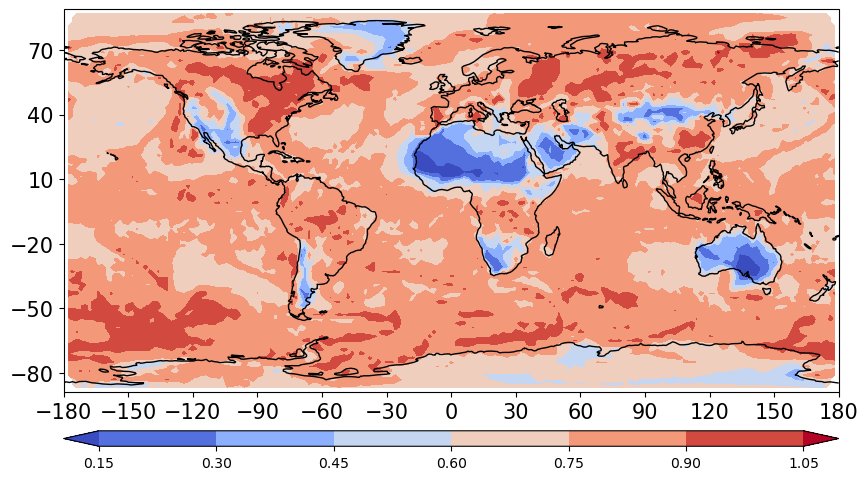

In [29]:
if __name__ == "__main__":

    # plot variable for quick plausibility check

    plotval=dsout.hurs[1][:][:] # -273.15
    lon=dsout.lon
    lat=dsout.lat

    plot_args = {
        # "levels": (tuple(np.arange(-30,31,2))),
        "cmap": plt.cm.coolwarm,
        "extend": 'both',
        "cbar_label": 'degC',
        "scalefac": 1
        }

    #-- create figure and axes instances
    dpi = 100
    fig = plt.figure(figsize=(1000/dpi, 1000/dpi), dpi=dpi)

    min_lon = -180
    max_lon = 180
    min_lat = -80
    max_lat = 80

    proj=ccrs.PlateCarree()

    ax = plt.axes(projection=proj)
    # ax = plt.axes(projection=ccrs.AlbersEqualArea())
    # ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_xticks(range(int(min_lon),int(max_lon)+30,30))
    ax.set_yticks(range(int(min_lat),int(max_lat)+30,30))
    ax.tick_params(axis="both",labelsize=15)
    # ax.set_extent([min_lon, max_lon, min_lat, max_lat]) # setting the borders of our map
   
    #-- draw coastlines, state and country boundaries, edge of map
    ax.add_feature(cfeature.COASTLINE)
    
    contourplot = ax.contourf(lon,lat,plot_args["scalefac"]*plotval,transform=proj,add_colorbar=False,**plot_args) # ,**cluster_plot_args,add_colorbar=False)
    cbar = plt.colorbar(contourplot,orientation='horizontal',pad=0.05,aspect=50,ax=ax)